## Training the EfficientNetV2 Model for Lens Finding

* You will need to install tensorflow_addons the first time you run this nb, as it is not in the tensorflow-2.9.0 kernel

In [1]:
%pip install tensorflow_addons

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras import regularizers
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.layers import Input, Dense, Dropout, Flatten, BatchNormalization as BatchNorm
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve
import tensorflow_addons as tfa
from datetime import date
import time

In [3]:
!nvidia-smi

Fri Jun  6 11:47:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.127.08             Driver Version: 550.127.08     CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          On  |   00000000:03:00.0 Off |                    0 |
| N/A   28C    P0             49W /  400W |       1MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

In [4]:
clean_deluxe = '/global/cfs/projectdirs/cosmo/work/users/xhuang/dr10_1/Clean-Samples/TS40_deluxe_clean'
data_path = clean_deluxe

 * clean deluxe is our highest quality sample, in the Clean-Samples dir you will find TS40 Baseline, which has more samples, but some positive and negative candidates may not be as clear, or have additional noise

In [5]:
xtrain = np.load(f"{data_path}/train_x.npy")
ytrain = np.load(f"{data_path}/train_y.npy").reshape(-1, 1)

xval = np.load(f"{data_path}/val_x.npy")
yval = np.load(f"{data_path}/val_y.npy").reshape(-1, 1)

xtrain = np.clip(xtrain, -1, 1)  
xval = np.clip(xval, -1, 1)
# Clipping the input images is a requirement for training using EfficientNet. 
# the input images have values mostly centered on zero, 
# but with a few large values from very bright objects that cause issues while training.

In [6]:
def preprocess(x, y):
    x = tf.image.random_flip_left_right(tf.image.random_flip_up_down(x))
    rg = tf.random.uniform(shape=[],minval=0, maxval=2 * np.pi, dtype=tf.float32)
    x = tfa.image.rotate(x, angles=rg, fill_mode = 'reflect')
    return x, y
# image augmentation to help prevent overfitting in training. 


options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

 
batch_size = 1024  
train = (tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
        .shuffle(len(ytrain), reshuffle_each_iteration=True, seed=42) 
        .repeat()
        .batch(batch_size)
        .map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

validate = (tf.data.Dataset.from_tensor_slices((xval, yval))
        .shuffle(len(yval))
        .repeat()
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)).with_options(options)

2025-06-06 11:47:49.822853: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-06 11:47:51.564057: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38336 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:03:00.0, compute capability: 8.0
2025-06-06 11:47:51.565889: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 38336 MB memory:  -> device: 1, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:41:00.0, compute capability: 8.0
2025-06-06 11:47:51.567529: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/devi

In [7]:
### To resume training, set epoch to last save epoch and set LR to last known LR.
START_EPOCH = 0
lr_stopped_at = 0.0

run_name = "F1"
today = date.today()
d1 = today.strftime("%d_%m_%Y") 
# this WILL override multiple runs on same day because of line 17, 
# rename run name to distinguish between runs on the same day

parent_dir = "_Time_Trials"
save_dir = parent_dir + "/" + d1 + run_name

if START_EPOCH == 0:
    !mkdir {parent_dir}
    !rm -rf {save_dir}
    !mkdir {save_dir}
    print("CREATED DIRECTORY")

mkdir: cannot create directory ‘_Time_Trials’: File exists
CREATED DIRECTORY


In [8]:
# def lr_fn(epoch, lr):
#     if (epoch == 130):
#         lr = lr * 0.5
#     return round(lr, 8)
# lr_schedule = LearningRateScheduler(lr_fn, verbose=1)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=10,
    verbose=1,
    min_lr=1e-6
)

metrics = tf.keras.metrics

In [9]:
strategy = tf.distribute.MirroredStrategy(cross_device_ops = tf.distribute.ReductionToOneDevice())

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [10]:
def create_fnet(lr=5e-4):
    inputlayer = Input(shape = (101,101,3))
    base_model = EfficientNetV2S(
    include_top=False,
    weights='imagenet',
    input_tensor=inputlayer,
    pooling='avg',
    classifier_activation='softmax',
    include_preprocessing=False
    )
    x = BatchNorm(axis=-1, momentum=0.99, epsilon=0.001)(base_model.output)
    x = Dropout(0.07654422996612698)(x) 
    x = Dense(161, kernel_regularizer=regularizers.l2(l=0.016),
              activity_regularizer=regularizers.l1(0.006),
              bias_regularizer=regularizers.l1(0.006), activation='relu')(x)
    x = Flatten()(x)
    output = Dense(1, activation = 'sigmoid')(x)

    model = tf.keras.models.Model(inputs=inputlayer, outputs=output)

    model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = lr),
            loss = tf.keras.losses.BinaryCrossentropy(from_logits=False),
            metrics = [metrics.AUC(num_thresholds=1000), metrics.Precision(0.9), metrics.Recall(0.9)])
    return model

In [11]:
with strategy.scope():
    model = create_fnet(0.000388)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [12]:
checkpoint = ModelCheckpoint(f"{save_dir}/chkpt.h5", monitor=f'val_auc', save_best_only=True, mode='max', verbose=1, save_weights_only=True)
csv_logger = CSVLogger(f"{save_dir}/training_history.csv", separator=',', append=True)
callbacks = [checkpoint, csv_logger, reduce_lr]

In [13]:
# model.load_weights('/global/homes/b/bkauf/Real_Testing/19_07_2024_TS40_EffNetB0_run2/chkpt.h5')

In [14]:
print("Number of devices: {}".format(strategy.num_replicas_in_sync))
start = time.time()
print(f'Start: {start}')

model.fit(train, validation_data=validate, epochs=160, 
           steps_per_epoch=(len(ytrain)//batch_size), callbacks=callbacks, verbose=1, 
           batch_size=batch_size, validation_steps=(len(yval)//batch_size))

end = time.time()
print(f'Total time running: {end-start}')

Number of devices: 4
Start: 1749235736.7543213
Epoch 1/160
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3').
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:GPU:0 then broadcast to ('/

2025-06-06 11:50:26.022448: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2025-06-06 11:50:30.916892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2025-06-06 11:50:32.517975: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2025-06-06 11:50:33.171913: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8302
2025-06-06 11:50:35.244566: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-06 11:50:35.244593: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2025-06-06 11:50:35.244616: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


92/92 [==============================] - ETA: 0s - loss: 2.5692 - auc: 0.7328 - precision: 0.0000e+00 - recall: 0.0000e+00     
Epoch 1: val_auc improved from -inf to 0.90775, saving model to _Time_Trials/06_06_2025F1/chkpt.h5
92/92 [==============================] - 139s 488ms/step - loss: 2.5692 - auc: 0.7328 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_loss: 0.9632 - val_auc: 0.9078 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - lr: 3.8800e-04
Epoch 2/160
92/92 [==============================] - ETA: 0s - loss: 0.4943 - auc: 0.9015 - precision: 1.0000 - recall: 0.0010         
Epoch 2: val_auc improved from 0.90775 to 0.97241, saving model to _Time_Trials/06_06_2025F1/chkpt.h5
92/92 [==============================] - 32s 352ms/step - loss: 0.4943 - auc: 0.9015 - precision: 1.0000 - recall: 0.0010 - val_loss: 0.2368 - val_auc: 0.9724 - val_precision: 0.9104 - val_recall: 0.1517 - lr: 3.8800e-04
Epoch 3/160
92/92 [==============================] - ETA: 0s - loss: 0.1653 

In [15]:
model.save_weights(f'{save_dir}/endrun.h5')

## Visualize Results

In [16]:
path_results = f"{save_dir}/training_history.csv"

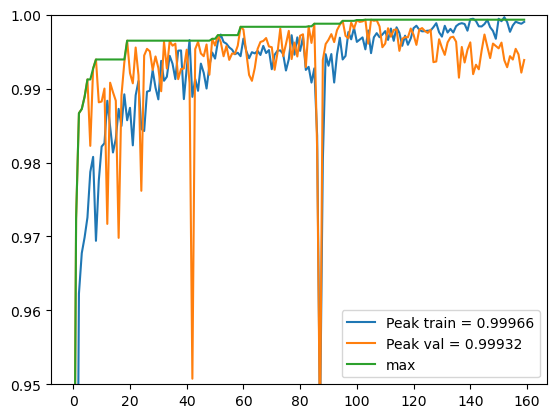

In [17]:
metric = ""
df = pd.read_csv(path_results)
val_auc_max = max(df["val_auc" + metric])
auc_max = max(df["auc" + metric])
largest = [max(df["val_auc" + metric][:i+1]) for i in range(len(df))]
plt.plot(df["auc" + metric],label='Peak train = {:.5f}'.format(auc_max))
plt.plot(df["val_auc" + metric], label='Peak val = {:.5f}'.format(val_auc_max))
plt.plot(largest, label='max')
plt.legend()
plt.ylim(0.95,1)
plt.show()


# print(f"Max train AUC: {auc_max:.5f}, Max val AUC: {val_auc_max:.5f}")

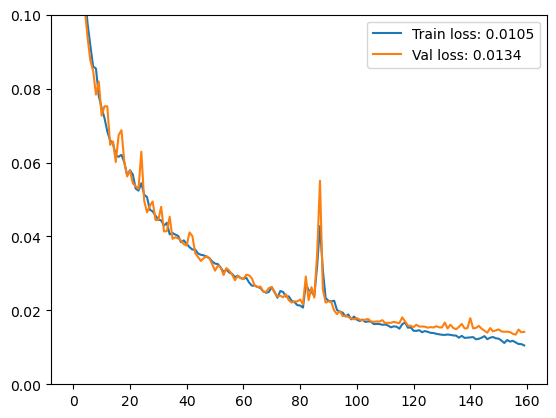

In [18]:
val_loss = min(df["val_loss"])
train_loss = min(df["loss"])
plt.plot(df["loss"],label=f'Train loss: {train_loss:.4f}')
plt.plot(df["val_loss"], label=f'Val loss: {val_loss:.4f}')
plt.ylim(top=0.1, bottom=0)
plt.legend()
plt.show()

In [19]:
endrun_preds = model.predict(xval)
model.load_weights(f'{save_dir}/chkpt.h5')
best_preds = model.predict(xval)

2025-06-06 13:11:57.809627: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_458550"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2438"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

1271/1271 [==============================] - 36s 21ms/step


2025-06-06 13:12:39.980759: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Did not find a shardable source, walked to a node which is not a dataset: name: "FlatMapDataset/_9"
op: "FlatMapDataset"
input: "PrefetchDataset/_8"
attr {
  key: "Targuments"
  value {
    list {
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: -2
  }
}
attr {
  key: "f"
  value {
    func {
      name: "__inference_Dataset_flat_map_slice_batch_indices_495552"
    }
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\023FlatMapDataset:2471"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: -1
        }
      }
    }
  }
}
attr {
  key: "output_types"
  value {
    list {
      type: DT_INT64
    }
  }
}
experimental_type {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_DATASET
    args {
      type_id: TFT_PR

1271/1271 [==============================] - 26s 20ms/step


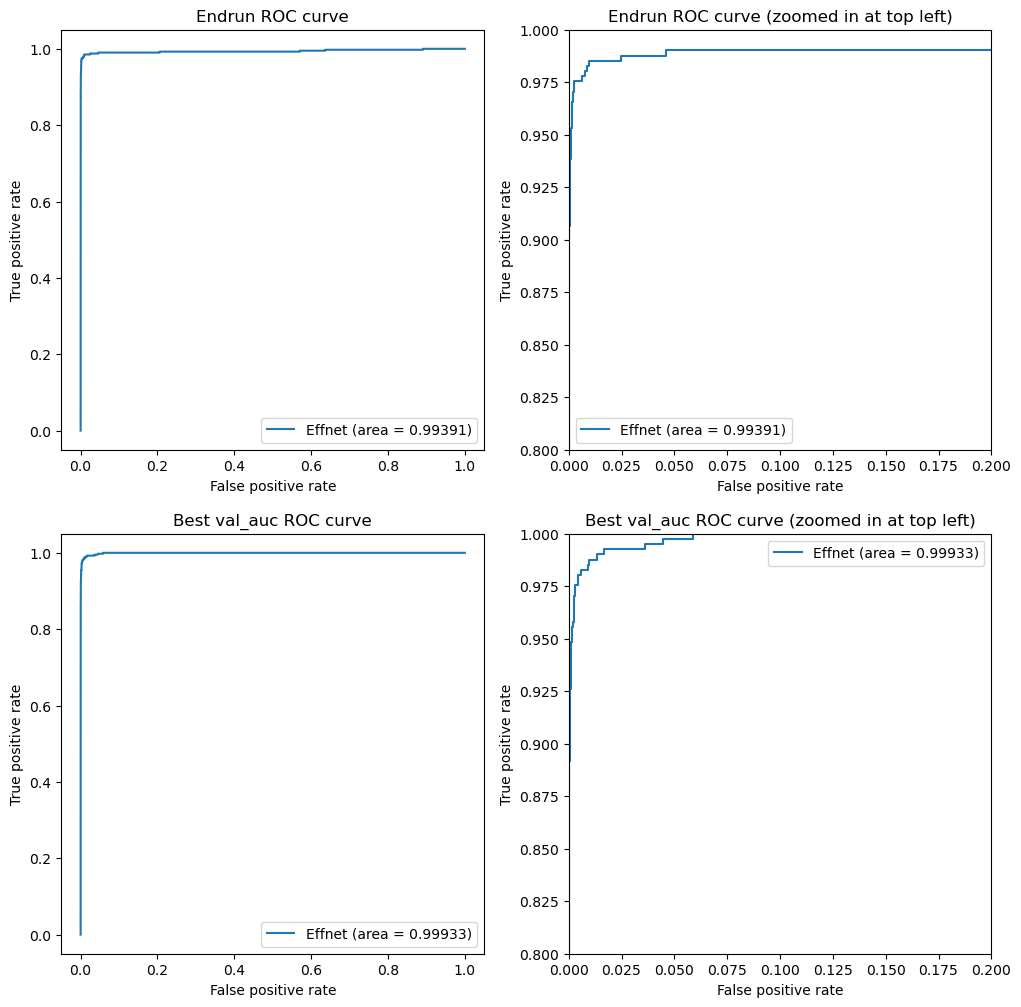

In [20]:
fpr, tpr, thresholds = roc_curve(yval, endrun_preds)
auc_roc = roc_auc_score(yval, endrun_preds)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,0].set_xlabel('False positive rate')
axs[0,0].set_ylabel('True positive rate')
axs[0,0].set_title('Endrun ROC curve')
axs[0,0].legend(loc='best')

axs[0,1].set_xlim(0, 0.2)
axs[0,1].set_ylim(0.8, 1)
axs[0,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,1].set_xlabel('False positive rate')
axs[0,1].set_ylabel('True positive rate')
axs[0,1].set_title('Endrun ROC curve (zoomed in at top left)')
axs[0,1].legend(loc='best')

fpr, tpr, thresholds = roc_curve(yval, best_preds)
auc_roc2 = roc_auc_score(yval, best_preds)

axs[1,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,0].set_xlabel('False positive rate')
axs[1,0].set_ylabel('True positive rate')
axs[1,0].set_title('Best val_auc ROC curve')
axs[1,0].legend(loc='best')

axs[1,1].set_xlim(0, 0.2)
axs[1,1].set_ylim(0.8, 1)
axs[1,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,1].set_xlabel('False positive rate')
axs[1,1].set_ylabel('True positive rate')
axs[1,1].set_title('Best val_auc ROC curve (zoomed in at top left)')
axs[1,1].legend(loc='best')

plt.show()

In [ ]:
save_dir = '/global/homes/b/bkauf/Clean_Training/0.999_f_deluxe'

In [ ]:
path_results = f"{save_dir}/training_history.csv"

In [ ]:
metric = ""
df = pd.read_csv(path_results)
val_auc_max = max(df["val_auc" + metric])
auc_max = max(df["auc" + metric])
largest = [max(df["val_auc" + metric][:i+1]) for i in range(len(df))]
plt.plot(df["auc" + metric],label='Peak train = {:.5f}'.format(auc_max))
plt.plot(df["val_auc" + metric], label='Peak val = {:.5f}'.format(val_auc_max))
plt.plot(largest, label='max')
plt.legend()
plt.ylim(0.95,1)
plt.show()


# print(f"Max train AUC: {auc_max:.5f}, Max val AUC: {val_auc_max:.5f}")

In [ ]:
val_loss = min(df["val_loss"])
train_loss = min(df["loss"])
plt.plot(df["loss"],label=f'Train loss: {train_loss:.4f}')
plt.plot(df["val_loss"], label=f'Val loss: {val_loss:.4f}')
plt.ylim(top=0.1, bottom=0)
plt.legend()
plt.show()

In [ ]:
endrun_preds = model.predict(xval)
model.load_weights(f'{save_dir}/chkpt.h5')
best_preds = model.predict(xval)

In [ ]:
fpr, tpr, thresholds = roc_curve(yval, endrun_preds)
auc_roc = roc_auc_score(yval, endrun_preds)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

axs[0,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,0].set_xlabel('False positive rate')
axs[0,0].set_ylabel('True positive rate')
axs[0,0].set_title('Endrun ROC curve')
axs[0,0].legend(loc='best')

axs[0,1].set_xlim(0, 0.2)
axs[0,1].set_ylim(0.8, 1)
axs[0,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc))
axs[0,1].set_xlabel('False positive rate')
axs[0,1].set_ylabel('True positive rate')
axs[0,1].set_title('Endrun ROC curve (zoomed in at top left)')
axs[0,1].legend(loc='best')

fpr, tpr, thresholds = roc_curve(yval, best_preds)
auc_roc2 = roc_auc_score(yval, best_preds)

axs[1,0].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,0].set_xlabel('False positive rate')
axs[1,0].set_ylabel('True positive rate')
axs[1,0].set_title('Best val_auc ROC curve')
axs[1,0].legend(loc='best')

axs[1,1].set_xlim(0, 0.2)
axs[1,1].set_ylim(0.8, 1)
axs[1,1].plot(fpr, tpr, label='Effnet (area = {:.5f})'.format(auc_roc2))
axs[1,1].set_xlabel('False positive rate')
axs[1,1].set_ylabel('True positive rate')
axs[1,1].set_title('Best val_auc ROC curve (zoomed in at top left)')
axs[1,1].legend(loc='best')

plt.show()